In [1]:
import os
if not os.path.exists('common.py'):
    print('trying to find project root directory by chaning to parent directory')
    os.chdir('..')
if os.path.exists('common.py'):
    print('all good')
else:
    print('could not find project root directory')

trying to find project root directory by chaning to parent directory
all good


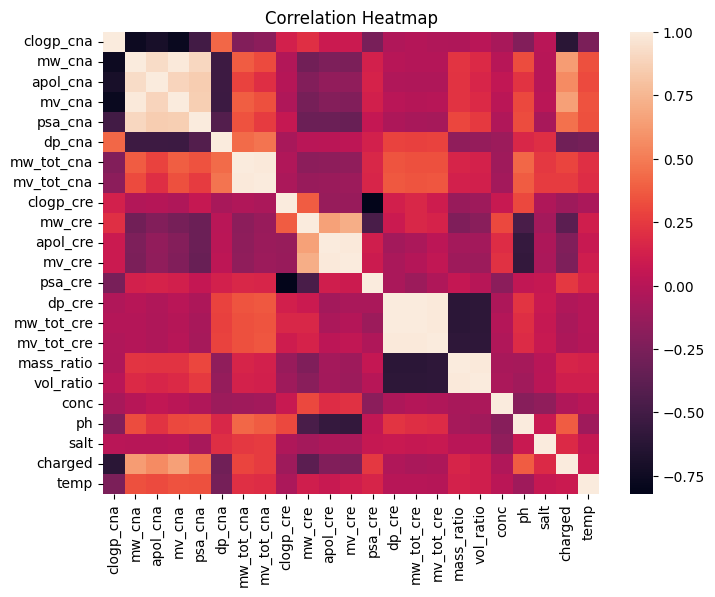

In [2]:
import data
from matplotlib import pyplot as plt
import seaborn as sns
from common import OUTPUTPATH

plt.figure(figsize=(8, 6))
# calculate the correlation matrix
corr = data.abbrev_x1.corr()

# plot the heatmap
ax=sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns).set(title='Correlation Heatmap')

plt.savefig(os.path.join(OUTPUTPATH, 'correlation_heatmap.pdf'), bbox_inches='tight', pad_inches=0)

In [3]:
# confusion matrix
import pandas as pd
predicted_order = [
        "(0,0,0)",
        "(0,0,1)",
        "(0,1,0)",
        "(0,1,1)",
        "(1,0,0)",
        "(1,0,1)",
        "(1,1,0)",
        "(1,1,1)",
        'Total'
    ]
def create_empty_df(predicted_order=predicted_order):
    df = pd.DataFrame(dict(zip(predicted_order, [[0 for _ in predicted_order] for _ in predicted_order]))) # specific columns order
    df.index = predicted_order # specific row order
    df = pd.concat([df], keys=['Predicted'])
    df = pd.concat([df.T], keys=['Actual'])
    return df
create_empty_df()



Predicted                                                  \
                 (0,0,0) (0,0,1) (0,1,0) (0,1,1) (1,0,0) (1,0,1) (1,1,0)   
Actual (0,0,0)         0       0       0       0       0       0       0   
       (0,0,1)         0       0       0       0       0       0       0   
       (0,1,0)         0       0       0       0       0       0       0   
       (0,1,1)         0       0       0       0       0       0       0   
       (1,0,0)         0       0       0       0       0       0       0   
       (1,0,1)         0       0       0       0       0       0       0   
       (1,1,0)         0       0       0       0       0       0       0   
       (1,1,1)         0       0       0       0       0       0       0   
       Total           0       0       0       0       0       0       0   

                              
               (1,1,1) Total  
Actual (0,0,0)       0     0  
       (0,0,1)       0     0  
       (0,1,0)       0     0  
       (0,1,1)       0     0  
       (1,0,0)       0     0  
       (1,0,1)       0     0  
       (1,1,0)       0     0  
       (1,1,1)       0     0  
       Total         0     0

In [4]:
import _pickle as cPickle
with open(r"./output/interpolation.pkl", "rb") as input_file:
    e = cPickle.load(input_file)

In [5]:
from modules.experiments import KFold

def modified_array(data): 
    return [ "(" + ",".join([str(code) for code in each[:-1]]) + ")" for each in data]

def confusion_matrix(model_name):
    """
    model_name: ['LR', 'GAM','RuleFit', 'RF']
    """
    df = create_empty_df()
    seed = 1000
    splitter = KFold(30, shuffle=True, random_state=seed)
    x, y = data.x1, data.y.replace(-1.0, 0.0)
    groups = data.comp_ids.array
    i = -1
    for train_idx, test_idx in splitter.split(x, y, groups):
        x_train, x_test = x.iloc[train_idx], x.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        # groups_train, groups_test = (None, None) if groups is None else (groups[train_idx], groups[test_idx])
        i +=1
        # LR
        est = e.fitted_[model_name][i]
        predicted = est.predict(x_test)
        predicted = modified_array(predicted)#[ "(" + ",".join([str(code) for code in each[:-1]]) + ")" for each in predicted]
        actual = modified_array(y_test.values)
        for i in range(len(predicted)):
            col, row = predicted_order.index(predicted[i]), predicted_order.index(actual[i])
            df.values[row][col] += 1
            df.values[row][-1] += 1
            df.values[-1][col] += 1
            df.values[-1][-1] += 1
    # df /= df.values[-1][-1]
    return df

In [6]:
# combine all the models
model_names = ['LR', 'GAM','RuleFit', 'RF']
df = dict(zip(model_names,
              [confusion_matrix(each) for each in model_names]))

In [7]:
df['LR'] # logistic model

Predicted                                                  \
                 (0,0,0) (0,0,1) (0,1,0) (0,1,1) (1,0,0) (1,0,1) (1,1,0)   
Actual (0,0,0)         4       8       8       0      12       0       0   
       (0,0,1)        66       4       8       0      21       0       0   
       (0,1,0)        33       0      44       0      12       0       2   
       (0,1,1)        24       0      10       0      11       0       3   
       (1,0,0)         9       0      26       0     193       0      14   
       (1,0,1)         7       0       0       0      12       0       0   
       (1,1,0)        12       0      21       0      14       0       7   
       (1,1,1)         1       0       1       0       5       0       0   
       Total         156      12     118       0     280       0      26   

                              
               (1,1,1) Total  
Actual (0,0,0)       0    32  
       (0,0,1)       0    99  
       (0,1,0)       0    91  
       (0,1,1)       0    48  
       (1,0,0)       0   242  
       (1,0,1)       0    19  
       (1,1,0)       0    54  
       (1,1,1)       0     7  
       Total         0   592

In [8]:
# check confusion matrix actual total column
import numpy as np
np.unique([each[:-1] for each in data.y.values], return_counts=True, axis=0)

(array([[0, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 1],
        [1, 0, 0],
        [1, 0, 1],
        [1, 1, 0],
        [1, 1, 1]]),
 array([ 32,  99,  91,  48, 242,  19,  54,   7]))

In [16]:
df['GAM'] # GAM

Predicted                                                  \
                 (0,0,0) (0,0,1) (0,1,0) (0,1,1) (1,0,0) (1,0,1) (1,1,0)   
Actual (0,0,0)        24       2       0       0       6       0       0   
       (0,0,1)         0      90       2       7       0       0       0   
       (0,1,0)         0       0      83       3       4       0       1   
       (0,1,1)         0       5       6      37       0       0       0   
       (1,0,0)         0       1       1       1     225       4      10   
       (1,0,1)         0       1       0       1       2      15       0   
       (1,1,0)         0       0       7       1      12       0      34   
       (1,1,1)         0       0       0       1       0       2       2   
       Total          24      99      99      51     249      21      47   

                              
               (1,1,1) Total  
Actual (0,0,0)       0    32  
       (0,0,1)       0    99  
       (0,1,0)       0    91  
       (0,1,1)       0    48  
       (1,0,0)       0   242  
       (1,0,1)       0    19  
       (1,1,0)       0    54  
       (1,1,1)       2     7  
       Total         2   592

In [17]:
df['RuleFit'] # rulefit

Predicted                                                  \
                 (0,0,0) (0,0,1) (0,1,0) (0,1,1) (1,0,0) (1,0,1) (1,1,0)   
Actual (0,0,0)        27       2       0       0       3       0       0   
       (0,0,1)         0      98       1       0       0       0       0   
       (0,1,0)         0       0      86       3       0       0       2   
       (0,1,1)         0       1       6      41       0       0       0   
       (1,0,0)         0       1       1       0     239       1       0   
       (1,0,1)         0       0       0       0       2      17       0   
       (1,1,0)         0       0       6       1       1       0      46   
       (1,1,1)         0       0       0       1       0       0       0   
       Total          27     102     100      46     245      18      48   

                              
               (1,1,1) Total  
Actual (0,0,0)       0    32  
       (0,0,1)       0    99  
       (0,1,0)       0    91  
       (0,1,1)       0    48  
       (1,0,0)       0   242  
       (1,0,1)       0    19  
       (1,1,0)       0    54  
       (1,1,1)       6     7  
       Total         6   592

In [18]:
df['RF'] # random forest

Predicted                                                  \
                 (0,0,0) (0,0,1) (0,1,0) (0,1,1) (1,0,0) (1,0,1) (1,1,0)   
Actual (0,0,0)        31       0       1       0       0       0       0   
       (0,0,1)         0      98       0       1       0       0       0   
       (0,1,0)         0       0      90       0       1       0       0   
       (0,1,1)         0       1       1      46       0       0       0   
       (1,0,0)         0       1       1       0     240       0       0   
       (1,0,1)         0       0       0       0       0      19       0   
       (1,1,0)         0       0       1       0       0       0      53   
       (1,1,1)         0       0       0       0       0       0       0   
       Total          31     100      94      47     241      19      53   

                              
               (1,1,1) Total  
Actual (0,0,0)       0    32  
       (0,0,1)       0    99  
       (0,1,0)       0    91  
       (0,1,1)       0    48  
       (1,0,0)       0   242  
       (1,0,1)       0    19  
       (1,1,0)       0    54  
       (1,1,1)       7     7  
       Total         7   592

/var/folders/c_/6873d_hj27z4bhy1l9x1tggnj8s0wd/T/ipykernel_51032/3365220624.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


Text(0.5, 1.03, 'Confusion Matrix Heatmap')

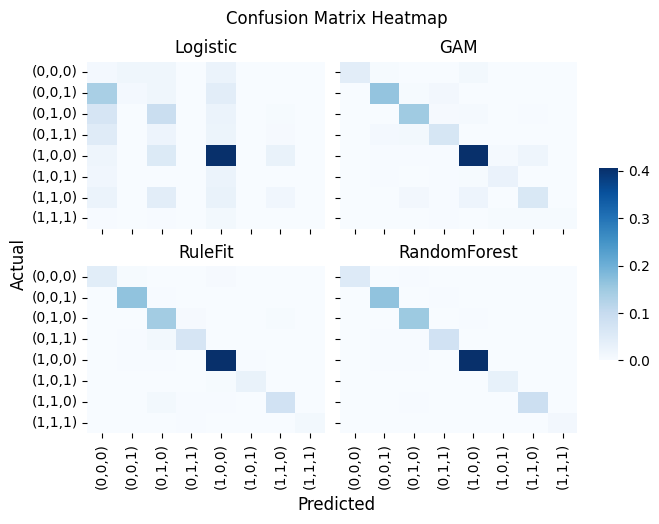

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def heatmap_subplot(df, title, ax=None, cbar=True, cbar_ax=None, cmap="Blues", predicted_order=predicted_order[:-1]):
    df = df.T['Actual'].drop(columns=['Total'])
    df = df.T['Predicted'].drop(columns=['Total'])

    sns.heatmap(df, 
            xticklabels=predicted_order,
            yticklabels=predicted_order, ax=ax, cbar=cbar, cbar_ax=cbar_ax, cmap=cmap).set(title=title)


fig, axn = plt.subplots(2, 2, sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

heatmap_subplot(df['LR']/592, title='Logistic', ax=axn.flat[0], cbar=None)
heatmap_subplot(df['GAM']/592, title='GAM', ax=axn.flat[1], cbar_ax=cbar_ax)
heatmap_subplot(df['RuleFit']/592, title='RuleFit', ax=axn.flat[2], cbar_ax=cbar_ax)
heatmap_subplot(df['RF']/592, title='RandomForest', ax=axn.flat[3], cbar_ax=cbar_ax)

fig.tight_layout(rect=[0, 0, .9, 1])
fig.supxlabel('Predicted', y=-0.02)
fig.supylabel('Actual', x=-0.01)
fig.suptitle('Confusion Matrix Heatmap', y=1.03)